# Prerequisites

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, Subset
import torchvision.models as models
from torchvision import datasets, transforms
import torch.optim as optim
from tqdm import tqdm

/opt/anaconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /opt/anaconda3/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <EEB3232B-F6A7-3262-948C-BB2F54905803> /opt/anaconda3/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
url = "https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded"

# Folder to save the dataset
output_folder = "data"
os.makedirs(output_folder, exist_ok=True)

# File name for the downloaded dataset
file_name = os.path.join(output_folder, "dataset.zip")

def download_file(url, output_path):
    """Download a file from a URL and save it locally."""
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(output_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        print(f"File downloaded successfully: {output_path}")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

# Download the dataset
download_file(url, file_name)

In [ ]:
# Extract downloaded dataset

import zipfile

with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(output_folder)
print("Dataset extracted successfully.")

In [2]:
# Data path in GDrive
# data_path = "/content/drive/MyDrive/datasets/augmented-datasets/Plant_leave_diseases_dataset_with_augmentation"
# Data path local hirzi
# data_path = "J:\\tesis\ sundana\\Plant_leave_diseases_dataset_with_augmentation"
# Data path mac
data_path = "/Users/firmansyahsundana/Documents/tesis/data"

In [3]:
total_samples = 0

for folder in os.listdir(data_path):
    print(folder, len(os.listdir(os.path.join(data_path, folder))))
    total_samples += len(os.listdir(os.path.join(data_path,folder)))

print('\n')
print('Total samples =>', total_samples)

Strawberry___healthy 1000
Grape___Black_rot 1180
Potato___Early_blight 1000
Blueberry___healthy 1502
Cherry___Powdery_mildew 1052
Tomato___Target_Spot 1404
Peach___healthy 1000
Potato___Late_blight 1000
Tomato___Late_blight 1909
Tomato___Tomato_mosaic_virus 1000
Pepper,_bell___healthy 1478
Orange___Haunglongbing_(Citrus_greening) 5507
Tomato___Leaf_Mold 1000
Grape___Leaf_blight_(Isariopsis_Leaf_Spot) 1076
Apple___Cedar_apple_rust 1000
Tomato___Bacterial_spot 2127
Grape___healthy 1000
Corn___Cercospora_leaf_spot Gray_leaf_spot 1000
Tomato___Early_blight 1000
Grape___Esca_(Black_Measles) 1383
Raspberry___healthy 1000
Tomato___healthy 1591
Corn___Northern_Leaf_Blight 1000
Tomato___Tomato_Yellow_Leaf_Curl_Virus 5357
Cherry___healthy 1000
Apple___Apple_scab 1001
Tomato___Spider_mites Two-spotted_spider_mite 1676
Corn___Common_rust 1192
Background_without_leaves 1143
Peach___Bacterial_spot 2297
Pepper,_bell___Bacterial_spot 1000
Tomato___Septoria_leaf_spot 1771
Corn___healthy 1162
Squash___P

# Dataset Preparation

In [4]:
from data_setup import create_dataloader

# Define transformations, including resizing, converting to tensor, and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (or the input size for your model)
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])

train_loader, val_loader, test_loader, class_names = create_dataloader(
    data_path = data_path,
    transform = transform,
    batch_size = 64,
)

In [5]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [8]:
num_classes = len(class_names)
print("Class Names:", class_names)
print("Num. classes: ", num_classes)

Class Names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yel

# Build Model

In [6]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'mps'

### MobileNet V1

In [ ]:
from models.mobilenetv1 import MobileNetV1

model_v0 = MobileNetV1(ch_in=3,n_classes=num_classes)  # Replace 1000 with the number of classes you have
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_v0.parameters(), lr=0.001)

In [ ]:
# from torchsummary import summary
from torchinfo import summary

summary(model_v0, input_size = (64, 3, 224, 224))

In [ ]:
from ptflops import get_model_complexity_info

flops, params = get_model_complexity_info(model_v0, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")

In [ ]:
from mac import calculate_total_mac

mobilenet_mac = calculate_total_mac(model_v0, (3, 224, 224))
mobilenet_mac

## MobileNetV2

In [ ]:
mobilenetv2 = models.mobilenet_v2(num_classes=num_classes)
mobilenetv2

In [ ]:
from torchinfo import summary
summary(mobilenetv2, (64, 3, 224, 224))

In [ ]:
from ptflops import get_model_complexity_info

flops, params = get_model_complexity_info(mobilenetv2, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")

## MobileNetV3 Large

In [ ]:
mobilenetv3_large = models.mobilenet_v3_large(num_classes=num_classes)

In [ ]:
from torchinfo import summary
summary(mobilenetv3_large, (64, 3, 224, 224))

In [ ]:
from ptflops import get_model_complexity_info

flops, params = get_model_complexity_info(mobilenetv3_large, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")

## MobileNetV3 Small

In [ ]:
mobilenetv3small = models.mobilenet_v3_small(num_classes=num_classes)

In [ ]:
from torchinfo import summary

summary(mobilenetv3small, (64, 3, 224, 224))

In [ ]:
from ptflops import get_model_complexity_info

flops, params = get_model_complexity_info(mobilenetv3small, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")

## SqueezeNet

In [ ]:
squeezenet = models.squeezenet.SqueezeNet(num_classes=num_classes)

In [ ]:
from torchinfo import summary
summary(squeezenet, (64, 3, 224, 224))

In [ ]:
from ptflops import get_model_complexity_info

flops, params = get_model_complexity_info(squeezenet, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")

## ShuffleNetV2

In [ ]:
shufflenetv2 = models.shufflenet_v2_x1_0(pretrained=False)
in_features = shufflenetv2.fc.in_features
shufflenetv2.fc = torch.nn.Linear(in_features, num_classes)

In [ ]:
from ptflops import get_model_complexity_info

flops, params = get_model_complexity_info(shufflenetv2, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")

## MobileNetV3+CBAM Large

In [8]:
from my_models.mobilenetv3_cbam import MobileNetV3WithCBAM

mobilenetv3_cbam_large = MobileNetV3WithCBAM(mode='large', num_classes=num_classes)

In [9]:
from torchinfo import summary

summary(mobilenetv3_cbam_large, (64, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
MobileNetV3WithCBAM                           [64, 39]                  --
├─Sequential: 1-1                             [64, 16, 112, 112]        --
│    └─Conv2d: 2-1                            [64, 16, 112, 112]        432
│    └─BatchNorm2d: 2-2                       [64, 16, 112, 112]        32
│    └─Hardswish: 2-3                         [64, 16, 112, 112]        --
├─ModuleList: 1-2                             --                        --
│    └─InvertedResidualWithCBAM: 2-4          [64, 16, 112, 112]        --
│    │    └─Conv2d: 3-1                       [64, 16, 112, 112]        144
│    │    └─BatchNorm2d: 3-2                  [64, 16, 112, 112]        32
│    │    └─ReLU6: 3-3                        [64, 16, 112, 112]        --
│    │    └─Conv2d: 3-4                       [64, 16, 112, 112]        256
│    │    └─BatchNorm2d: 3-5                  [64, 16, 112, 112]        32
│    └─InvertedRe

In [10]:
from ptflops import get_model_complexity_info

flops, params = get_model_complexity_info(mobilenetv3_cbam_large, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")

MobileNetV3WithCBAM(
  1.02 M, 100.000% Params, 162.51 MMac, 99.961% MACs, 
  (first_conv): Sequential(
    464, 0.046% Params, 5.82 MMac, 3.580% MACs, 
    (0): Conv2d(432, 0.042% Params, 5.42 MMac, 3.333% MACs, 3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, 0.003% Params, 401.41 KMac, 0.247% MACs, 16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Hardswish(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
  )
  (blocks): ModuleList(
    (0): InvertedResidualWithCBAM(
      464, 0.046% Params, 6.02 MMac, 3.704% MACs, 
      (depthwise): Conv2d(144, 0.014% Params, 1.81 MMac, 1.111% MACs, 16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
      (depthwise_bn): BatchNorm2d(32, 0.003% Params, 401.41 KMac, 0.247% MACs, 16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (depthwise_relu): ReLU6(0, 0.000% Params, 200.7 KMac, 0.123% MACs, inplace=True)
      (project): Conv2

# Train

In [ ]:
from utils import plot_training_history, train_model

## MobileNet V1

In [ ]:
# Run training and testing
num_epochs = 10
# Train the model
train_model(model_v0, train_loader, val_loader, num_epochs)

Check final loss

In [ ]:
model_v0.eval()

total_loss = 0.0
with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model_v0(inputs)
    loss = criterion(outputs, labels)
    total_loss += loss.item() * inputs.size(0)

# Calculate avg loss
final_loss = total_loss / len(test_loader)
print(f"Final Loss: {final_loss:.4f}")

In [ ]:
# Save a full checkpoint with additional details
checkpoint = {
    'model_state_dict': model_v0.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),  # Optional if you need it
    'epoch': num_epochs,
    'loss': final_loss,  # Replace final_loss with your final loss value
}
torch.save(model_v0.state_dict(), '/content/drive/MyDrive/checkpoints/model_v0.pth')

## MobileNetV2

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetv2.parameters(), lr=0.001)

In [ ]:
from utils import plot_training_history, train_model

num_epochs = 100
history_mobilenetv2 = train_model(mobilenetv2, train_loader, val_loader, num_epochs, criterion, optimizer, device='mps')

## MobileNetV3 Large

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetv3_large.parameters(), lr=0.001)

In [ ]:
num_epochs = 100
history = train_model(mobilenetv3_large, train_loader, val_loader, num_epochs, criterion, optimizer, device='mps')

In [ ]:

plot_training_history(history)

## MobileNetV3 Small

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetv3small.parameters(), lr=0.001)

In [ ]:
num_epochs = 100
history = train_model(mobilenetv3small, train_loader, val_loader, num_epochs, criterion, optimizer, device="mps")

In [ ]:
plot_training_history(history)

## SqueezeNet

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(squeezenet.parameters(), lr=0.001)

In [ ]:
num_epochs = 10
history = train_model(squeezenet, train_loader, val_loader, num_epochs, criterion, optimizer, device="mps")

In [ ]:
plot_training_history(history)

In [ ]:
squeezenet.eval()

total_loss = 0.0
with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = squeezenet(inputs)
    loss = criterion(outputs, labels)
    total_loss += loss.item() * inputs.size(0)

# Calculate avg loss
final_loss = total_loss / len(test_loader)
print(f"Final Loss: {final_loss:.4f}")

In [ ]:
# Save a full checkpoint with additional details
checkpoint = {
    'model_state_dict': squeezenet.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),  # Optional if you need it
    'epoch': num_epochs,
    'loss': final_loss,  # Replace final_loss with your final loss value
}
torch.save(squeezenet.state_dict(), '/Users/firmansyahsundana/Documents/tesis/checkpoints/squeezenet.pth')

## ShuffleNetV2

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(shufflenetv2.parameters(), lr=0.001)

In [ ]:
from utils import plot_training_history, train_model
num_epochs = 100
history = train_model(shufflenetv2, train_loader, val_loader, num_epochs, criterion, optimizer, device="mps")

In [ ]:
plot_training_history(history)

## MobileNetV3+CBAM Large

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetv3_cbam_large.parameters(), lr=0.001)

In [13]:
from utils import plot_training_history, train_model
num_epochs = 100
history = train_model(mobilenetv3_cbam_large, train_loader, val_loader, num_epochs, criterion, optimizer, device="mps")

Epoch 1/100: 100%|██████████| 673/673 [09:03<00:00,  1.24batch/s]


Epoch [1/100], Train Loss: 1.0145, Train Accuracy: 69.68%, Val Loss: 0.5242, Val Accuracy: 83.21%
Checkpoint saved to checkpoints/best_model_epoch_1.pth


Epoch 2/100: 100%|██████████| 673/673 [09:03<00:00,  1.24batch/s]


Epoch [2/100], Train Loss: 0.2817, Train Accuracy: 90.64%, Val Loss: 0.4802, Val Accuracy: 85.96%
Checkpoint saved to checkpoints/best_model_epoch_2.pth


Epoch 3/100: 100%|██████████| 673/673 [10:55<00:00,  1.03batch/s]


Epoch [3/100], Train Loss: 0.1744, Train Accuracy: 94.13%, Val Loss: 1.2094, Val Accuracy: 69.24%


Epoch 4/100: 100%|██████████| 673/673 [10:38<00:00,  1.05batch/s]


Epoch [4/100], Train Loss: 0.1273, Train Accuracy: 95.78%, Val Loss: 0.2962, Val Accuracy: 90.90%
Checkpoint saved to checkpoints/best_model_epoch_4.pth


Epoch 5/100: 100%|██████████| 673/673 [10:43<00:00,  1.05batch/s]


Epoch [5/100], Train Loss: 0.1077, Train Accuracy: 96.39%, Val Loss: 0.3131, Val Accuracy: 90.52%


Epoch 6/100: 100%|██████████| 673/673 [10:47<00:00,  1.04batch/s]


Epoch [6/100], Train Loss: 0.0854, Train Accuracy: 97.10%, Val Loss: 0.1376, Val Accuracy: 95.68%
Checkpoint saved to checkpoints/best_model_epoch_6.pth


Epoch 7/100: 100%|██████████| 673/673 [11:34<00:00,  1.03s/batch]


Epoch [7/100], Train Loss: 0.0779, Train Accuracy: 97.44%, Val Loss: 0.1742, Val Accuracy: 94.70%


Epoch 8/100: 100%|██████████| 673/673 [10:37<00:00,  1.06batch/s]


Epoch [8/100], Train Loss: 0.0674, Train Accuracy: 97.72%, Val Loss: 0.1824, Val Accuracy: 94.61%


Epoch 9/100: 100%|██████████| 673/673 [10:30<00:00,  1.07batch/s]


Epoch [9/100], Train Loss: 0.0593, Train Accuracy: 97.94%, Val Loss: 0.9737, Val Accuracy: 78.73%


Epoch 10/100: 100%|██████████| 673/673 [10:49<00:00,  1.04batch/s]


Epoch [10/100], Train Loss: 0.0631, Train Accuracy: 97.87%, Val Loss: 0.6581, Val Accuracy: 85.81%


Epoch 11/100: 100%|██████████| 673/673 [10:43<00:00,  1.05batch/s]


Epoch [11/100], Train Loss: 0.0456, Train Accuracy: 98.42%, Val Loss: 0.3212, Val Accuracy: 91.74%
Early stopping triggered!
Training completed in: 125m 26s


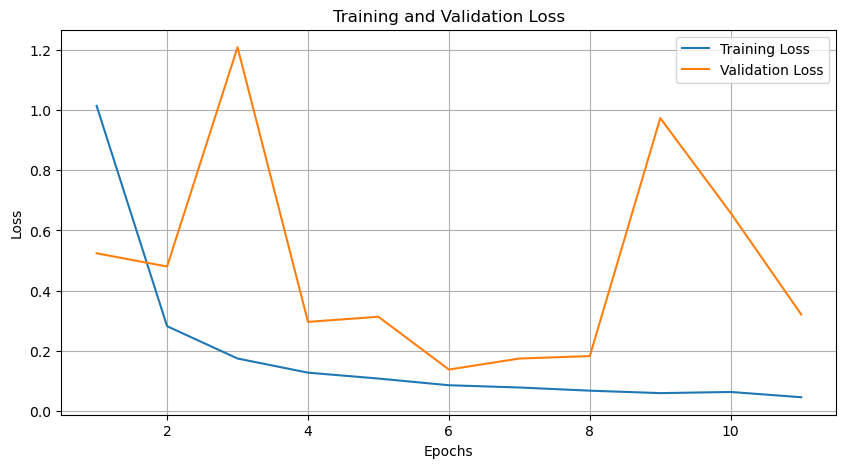

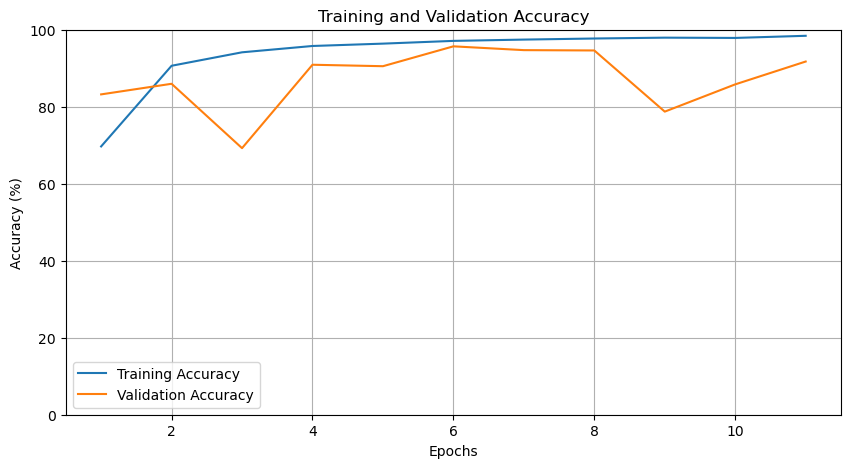

In [14]:
plot_training_history(history)

# Evaluation

In [15]:
from utils import evaluate_model

# Access the classes from the underlying dataset
class_names = test_loader.dataset.dataset.classes
print("Class Names:", class_names)

Class Names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yel

## MobileNet V1

In [ ]:
# Load model

loaded_model_v0 = MobileNetV1(ch_in=3, n_classes=num_classes)
loaded_model_v0.load_state_dict(torch.load(f='/Users/firmansyahsundana/Documents/tesis/checkpoints/mobilenetv1.pth', map_location="mps"))
loaded_model_v0

In [ ]:
cm, performance_table = evaluate_model(loaded_model_v0, test_loader, class_names)

In [ ]:
performance_table

### Inference Time

In [ ]:
from utils import calculate_inference_time

mobilenetv1_avg_time = calculate_inference_time(loaded_model_v0, test_loader)
print(f"Average Inference Time per Batch: {mobilenetv1_avg_time:.2f} ms")

## MobileNet V3 Large

In [ ]:
# Load model

loaded_mobilenetv3_large = models.mobilenet_v3_large(num_classes=num_classes)
loaded_mobilenetv3_large.load_state_dict(torch.load(f='/Users/firmansyahsundana/Documents/tesis/checkpoints/mobilenetv3_large.pth', map_location="mps"))
loaded_mobilenetv3_large

In [ ]:
from utils import evaluate_model

cm, performance_table, final_loss = evaluate_model(loaded_mobilenetv3_large, criterion, test_loader, class_names, device='mps')

In [ ]:
performance_table

### Inference Time

In [ ]:
from utils import calculate_inference_time

mobilenetv3_avg_time = calculate_inference_time(loaded_mobilenetv3_large, test_loader)
print(f"Average Inference Time per Batch: {mobilenetv3_avg_time:.2f} ms")

## MobileNet V3 Small

In [ ]:
# Load model

loaded_mobilenetv3_small = models.mobilenet_v3_small(num_classes=num_classes)
loaded_mobilenetv3_small.load_state_dict(torch.load(f='/Users/firmansyahsundana/Documents/tesis/checkpoints/mobilenetv3_small.pth', map_location="mps"))
loaded_mobilenetv3_small

In [ ]:
from utils import evaluate_model

cm, performance_table, final_loss = evaluate_model(loaded_mobilenetv3_small, criterion, test_loader, class_names, device=device)

In [ ]:
from utils import calculate_inference_time

mobilenetv3_small_avg_time = calculate_inference_time(loaded_mobilenetv3_small, test_loader)
print(f"Average Inference Time per Batch: {mobilenetv3_small_avg_time:.2f} ms")

## SqueezeNet

In [ ]:
from utils import evaluate_model

cm, performance_table, final_loss = evaluate_model(squeezenet, criterion, test_loader, class_names, device=device)

In [ ]:
performance_table

### Inference Time

In [ ]:
# Load model

loaded_squeezenet = SqueezeNet(num_classes=num_classes)
loaded_squeezenet.load_state_dict(torch.load(f='/Users/firmansyahsundana/Documents/tesis/checkpoints/squeezenet.pth', map_location="mps"))
loaded_squeezenet

In [ ]:
from utils import calculate_inference_time

squeezenet_avg_time = calculate_inference_time(loaded_squeezenet, test_loader)
print(f"Average Inference Time per Batch: {squeezenet_avg_time:.2f} ms")

In [ ]:
print(f"Average Inference Time per Batch: {squeezenet_avg_time:.2f} ms")

## ShuffleNetV2

### Inference Time

In [ ]:
# Load model

loaded_shufflenetv2 = models.shufflenet_v2_x1_0(num_classes=num_classes)
loaded_shufflenetv2.load_state_dict(torch.load(f='/Users/firmansyahsundana/Documents/tesis/checkpoints/best_model_epoch_13.pth', map_location="mps"))
loaded_shufflenetv2

In [ ]:
from utils import evaluate_model

cm, performance_table, final_loss = evaluate_model(loaded_shufflenetv2, criterion, test_loader, class_names, device=device)

In [ ]:
from utils import calculate_inference_time

shufflenetv2_avg_time = calculate_inference_time(loaded_shufflenetv2, test_loader)
print(f"Average Inference Time per Batch: {shufflenetv2_avg_time:.2f} ms")

## MobileNetV3+CBAM Large

In [17]:
# Load model

loaded_mobilenetv3_cbam_large = MobileNetV3WithCBAM(mode='large', num_classes=num_classes)
loaded_mobilenetv3_cbam_large.load_state_dict(torch.load(f='/Users/firmansyahsundana/Documents/tesis/checkpoints/mobilenetv3_cbam_large.pth', map_location="mps"))

<All keys matched successfully>

Final Loss: 7.9715


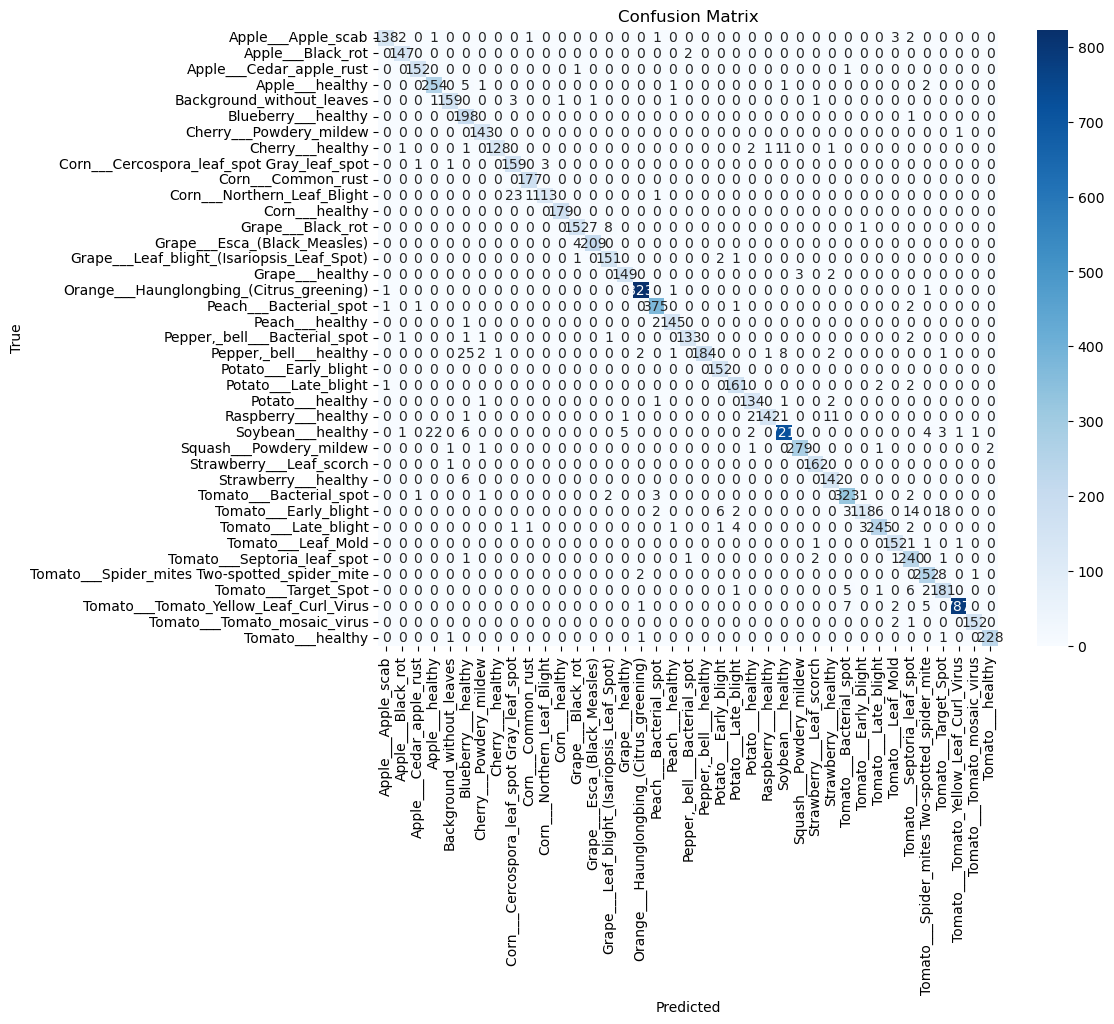

Accuracy: 0.96
Precision: 0.96
Recall: 0.96
F1 Score: 0.9580


In [18]:
from utils import evaluate_model

cm, performance_table, final_loss = evaluate_model(loaded_mobilenetv3_cbam_large, criterion, test_loader, class_names, device=device)

In [19]:
from utils import calculate_inference_time

mobilenetv3_cbam_large_avg_time = calculate_inference_time(loaded_mobilenetv3_cbam_large, test_loader)
print(f"Average Inference Time per Batch: {mobilenetv3_cbam_large_avg_time:.2f} ms")

Average Inference Time per Batch: 1813.23 ms


# Results

## Model Performance

In [20]:
import pandas as pd

mobilenetv1_results = {
    "model_name": "MobileNetV1",
    "accuracy": 0.97,
    "precision": 0.97,
    "recall": 0.97,
    "f1-score": 0.9731
}

mobilenetv3large_results = {
    "model_name": "MobileNetV3 Large",
    "accuracy": 0.93,
    "precision": 0.94,
    "recall": 0.93,
    "f1-score": 0.9326
}

mobilenetv3small_results = {
    "model_name": "MobileNetV3 Small",
    "accuracy": 0.95,
    "precision": 0.95,
    "recall": 0.95,
    "f1-score": 0.9467
}

mobilenetv2_result = {
    "model_name": "MobileNetV2",
    "accuracy": None,
    "precision": None,
    "recall": None,
    "f1-score": None
}

squeezenet_results = {
    "model_name": "SqueezeNet",
    "accuracy": 0.08,
    "precision": 0.01,
    "recall": 0.08,
    "f1-score": 0.0132
}

shufflenetv2_results = {
    "model_name": "ShuffleNetV2",
    "accuracy": 0.97,
    "precision": 0.97,
    "recall": 0.97,
    "f1-score": 0.9661
}

mobilenetv3_cbam_large_results = {
    "model_name": "MobileNetV3+CBAM Large",
    "accuracy": 0.96,
    "precision": 0.96,
    "recall": 0.96,
    "f1-score": 0.9580
}

In [21]:
compare_results = pd.DataFrame([mobilenetv1_results, 
                                mobilenetv3large_results, 
                                mobilenetv3small_results, 
                                squeezenet_results, 
                                shufflenetv2_results,
                                mobilenetv3_cbam_large_results])
compare_results

,model_name,accuracy,precision,recall,f1-score
0,MobileNetV1,0.97,0.97,0.97,0.9731
1,MobileNetV3 Large,0.93,0.94,0.93,0.9326
2,MobileNetV3 Small,0.95,0.95,0.95,0.9467
3,SqueezeNet,0.08,0.01,0.08,0.0132
4,ShuffleNetV2,0.97,0.97,0.97,0.9661
5,MobileNetV3+CBAM Large,0.96,0.96,0.96,0.9580


## Model Complexity

In [22]:
import pandas as pd

mobilenetv1_complex = {
    "model_name": "MobileNetV1",
    "FLOPs": f"{588_000_000 / 1_000_000:.1f}M",
    "MACs": f"{294_015_000 / 1_000_000:.1f}M",
    "Params" : f"{3_250_000 / 1000:.1f}K",
    "training (minutes)": 200,
    "inference (ms)": 8.98
}

mobilenetv2_complex = {
    "model_name": "MobileNetV2",
    "FLOPs": f"{319_070_000 / 1_000_000:.1f}M",
    "MACs": f"{319_070_000 / 2 / 1000000:.1f}M",
    "Params" : f"{2_270_000 / 1000:.1f}K",
    "training (minutes)": None,
    "inference (ms)": None
}

mobilenetv3_large_complex = {
    "model_name": "MobileNetv3 Large",
    "FLOPs": f"{230_090_000 / 1_000_000:.1f}M",
    "MACs": f"{230_090_000 / 2 / 1000000:.1f}M",
    "Params": f"{4_250_000 / 1000:.1f}K",
    "training (minutes)": 224,
    "inference (ms)": 2928.81
}

mobilenetv3_small_complex = {
    "model_name": "MobileNetV3 Small",
    "FLOPs": f"{59_930_000 / 1_000_000:.1f}M",
    "MACs": f"{59_930_000 / 2 / 1000000:.1f}M",
    "Params": f"{1_560_000 / 1000:.1f}K",
    "training (minutes)": 127,
    "inference (ms)": 1214.54
}

squeezenet_complex = {
    "model_name": "SqueezeNet",
    "FLOPs": f"{752_860_000 / 1_000_000:.1f}M",
    "MACs": f"{752_860_000 / 2 / 1000000:.1f}M",
    "Params": f"{755_430 / 1000:.1f}K",
    "training (minutes)": 161,
    "inference (ms)": 1684.52
}

shufflenetv2_complex = {
    "model_name": "ShuffleNetV2",
    "FLOPs": f"{151_400_000 / 1_000_000:.1f}M",
    "MACs": f"{151_400_000 / 2 / 1000000:.1f}M",
    "Params": f"{1_290_000 / 1000:.1f}K",
    "training (minutes)": 159,
    "inference (ms)": 1226.62
}

mobilenetv3_cbam_large_complex = {
    "model_name": "MobileNetV3+CBAM Large",
    "FLOPs": f"{164_430_000 / 1_000_000:.1f}M",
    "MACs": f"{164_430_000 / 2 / 1000000:.1f}M",
    "Params": f"{1_020_000 / 1000:.1f}K",
    "training (minutes)": 125,
    "inference (ms)": 1813.23
}

In [23]:
compare_complex = pd.DataFrame([mobilenetv1_complex, 
                                mobilenetv2_complex, 
                                mobilenetv3_large_complex, 
                                mobilenetv3_small_complex, 
                                squeezenet_complex, 
                                shufflenetv2_complex,
                                mobilenetv3_cbam_large_complex])
compare_complex

,model_name,FLOPs,MACs,Params,training (minutes),inference (ms)
0,MobileNetV1,588.0M,294.0M,3250.0K,200.0,8.98
1,MobileNetV2,319.1M,159.5M,2270.0K,NaN,NaN
2,MobileNetv3 Large,230.1M,115.0M,4250.0K,224.0,2928.81
3,MobileNetV3 Small,59.9M,30.0M,1560.0K,127.0,1214.54
4,SqueezeNet,752.9M,376.4M,755.4K,161.0,1684.52
5,ShuffleNetV2,151.4M,75.7M,1290.0K,159.0,1226.62
6,MobileNetV3+CBAM Large,164.4M,82.2M,1020.0K,125.0,1813.23
